In [1]:
# Adds link to the scripts folder
import sys
import os
sys.path.append("../scripts/")
import matplotlib.pyplot as plt
import numpy as np

from trajectory import Trajectory, create_trajectory_list, create_all_patient_trajectories
from hivevo.patients import Patient
import filenames
import copy
from activity import get_average_activity

## Creation of the trajectory lists and putting them in dictionnaries

Format of the dictionnaries : trajectories[region][rev/non_rev/syn/non_syn]

In [2]:
regions = ["env", "pol", "gag"]
trajectories = {}

for region in regions:
    # Create the dictionary with the different regions
    tmp_trajectories = create_all_patient_trajectories(region)
    tmp_trajectories = [traj for traj in tmp_trajectories if traj.t[-1] != 0]
    trajectories[region] = tmp_trajectories

    # Split into sub dictionnaries (rev, non_rev and all)
    rev = [traj for traj in trajectories[region] if traj.reversion == True]
    non_rev = [traj for traj in trajectories[region] if traj.reversion == False]
    syn = [traj for traj in trajectories[region] if traj.synonymous == True]
    non_syn = [traj for traj in trajectories[region] if traj.synonymous == False]
    trajectories[region] = {"rev": rev, "non_rev": non_rev,
                            "syn": syn, "non_syn": non_syn, "all": trajectories[region]}

## Computation of the mean activity in time

In [44]:
def get_mean_in_time(trajectories, nb_bins=15, freq_range=[0.4, 0.6]):
    """
    Computes the mean frequency in time of a set of trajectories from the point they are seen in the freq_range window.
    Returns the middle of the time bins and the computed frequency mean.
    """
    # Create bins and select trajectories going through the freq_range
    time_bins = np.linspace(-950, 2000, nb_bins)
    trajectories = [traj for traj in trajectories if np.sum(np.logical_and(
        traj.frequencies >= freq_range[0], traj.frequencies < freq_range[1]), dtype=bool)]

    # Offset trajectories to set t=0 at the point they are seen in the freq_range and adds all the frequencies / times
    # to arrays for later computation of mean
    t_traj = np.array([])
    f_traj = np.array([])
    for traj in trajectories:
        idx = np.where(np.logical_and(traj.frequencies >=
                                      freq_range[0], traj.frequencies < freq_range[1]))[0][0]
        traj.t = traj.t - traj.t[idx]
        t_traj = np.concatenate((t_traj, traj.t))
        f_traj = np.concatenate((f_traj, traj.frequencies))

    # Binning of all the data in the time bins
    filtered_fixed = [traj for traj in trajectories if traj.fixation == "fixed"]
    filtered_lost = [traj for traj in trajectories if traj.fixation == "lost"]
    freqs, fixed, lost = [], [], []
    for ii in range(len(time_bins) - 1):
        freqs = freqs + [f_traj[np.logical_and(t_traj >= time_bins[ii], t_traj < time_bins[ii + 1])]]
        fixed = fixed + [len([traj for traj in filtered_fixed if traj.t[-1] < time_bins[ii]])]
        lost = lost + [len([traj for traj in filtered_lost if traj.t[-1] < time_bins[ii]])]

    # Computation of the mean in each bin, active trajectories contribute their current frequency,
    # fixed contribute1 and lost contribute 0
    mean = []
    for ii in range(len(freqs)):
        mean = mean + [np.sum(freqs[ii]) + fixed[ii]]
        mean[-1] /= (len(freqs[ii]) + fixed[ii] + lost[ii])

    nb_active = [len(freq) for freq in freqs]
    nb_dead = [fixed[ii] + lost[ii] for ii in range(len(fixed))]

    return 0.5 * (time_bins[1:] + time_bins[:-1]), mean, nb_active, nb_dead


means = {}
freq_ranges = [[0.2, 0.4], [0.4, 0.6], [0.6, 0.8]]
times = []

for freq_range in freq_ranges:
    means[str(freq_range)] = {}
    for region in regions:
        means[str(freq_range)][region] = {}
        for key in trajectories[region].keys():
            times, means[str(freq_range)][region][key], _, _ = get_mean_in_time(trajectories[region][key], freq_range=freq_range)

# Mean frequency in time plot

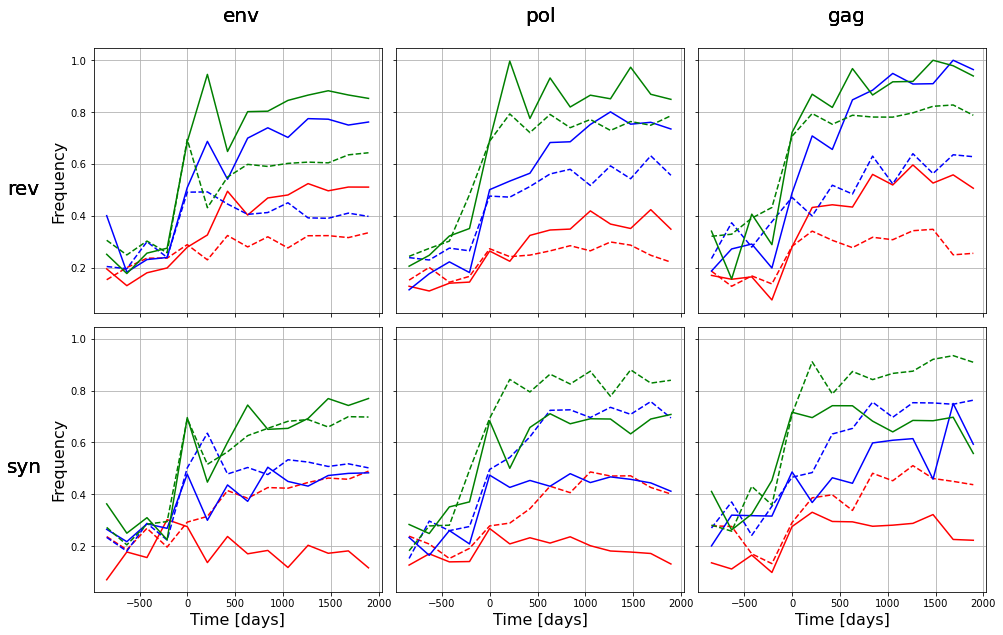

In [63]:
import matplotlib.gridspec as gridspec

colors = ["r", "b", "g"]
fontsize=16
fontsize2 = 20

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(16,10), sharex=True, sharey=True)
# fig.tight_layout()
for idx_row, split_type in enumerate([["rev", "non_rev"], ["syn", "non_syn"]]):
    for idx_col, region in enumerate(regions):
        for idx_colors,freq_range in enumerate(freq_ranges):
            axs[idx_row, idx_col].plot(times, means[str(freq_range)][region][split_type[0]], f'{colors[idx_colors]}-')
            axs[idx_row, idx_col].plot(times, means[str(freq_range)][region][split_type[1]], f'{colors[idx_colors]}--')
            axs[idx_row, idx_col].grid()
            if idx_row == 1:
                axs[idx_row,idx_col].set_xlabel("Time [days]", fontsize=fontsize)
            if idx_col == 0:
                axs[idx_row,idx_col].set_ylabel("Frequency", fontsize=fontsize)
                axs[idx_row,idx_col].text(-0.3, 0.45, split_type[0], transform=axs[idx_row,idx_col].transAxes, fontsize=fontsize2)
            if idx_row == 0:
                axs[idx_row,idx_col].text(0.45, 1.1, region, transform=axs[idx_row,idx_col].transAxes, fontsize=fontsize2)

fig.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig("Mean_frequency_in_time", format="png")


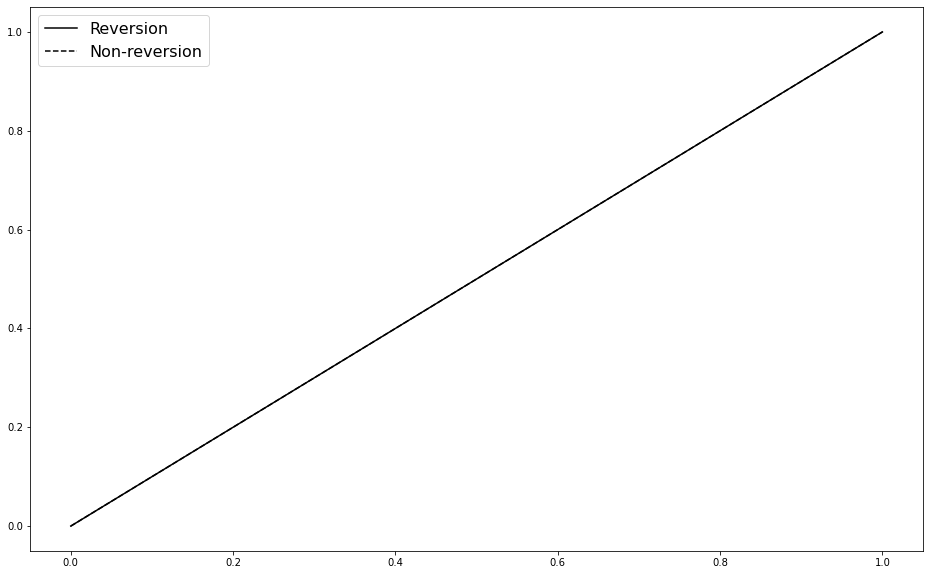

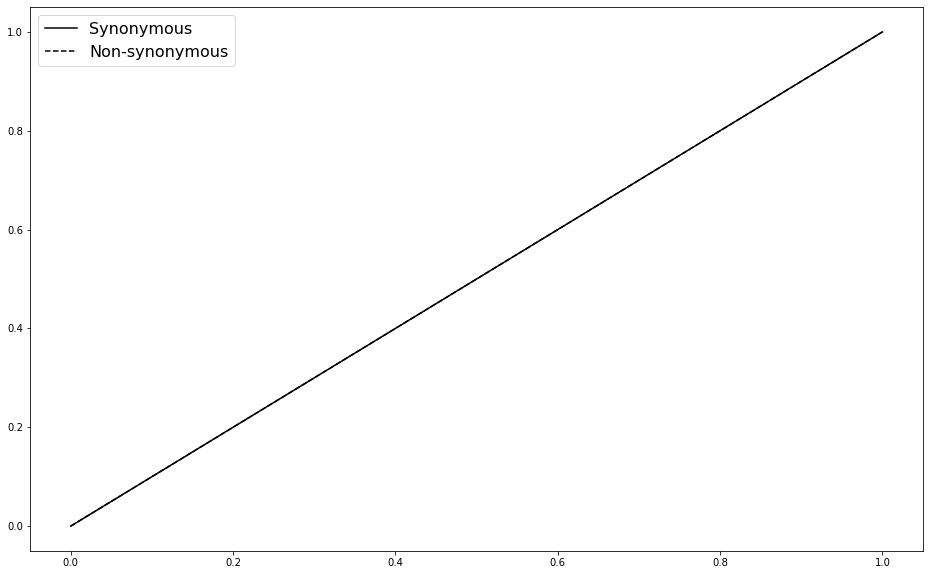

In [67]:
plt.figure(figsize=(16,10))
plt.plot([0,1], [0,1], 'k-')
plt.plot([0,1], [0,1], 'k--')
plt.legend(["Reversion", "Non-reversion"], fontsize=16)
plt.savefig("Legend1", format="png")

plt.figure(figsize=(16,10))
plt.plot([0,1], [0,1], 'k-')
plt.plot([0,1], [0,1], 'k--')
plt.legend(["Synonymous", "Non-synonymous"], fontsize=16)
plt.savefig("Legend2", format="png")